---
* ### Import as libs  
---

In [79]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices, get_G, get_F

---
* ### Função para plotar, printar TF e matriz
---

In [80]:
def plot(time, y_matriz, title, cols_name, time_aux=None, y_matriz_aux=None):
    n_row, n_col = len(y_matriz), len(y_matriz[0])
    
    # altura = 1 * n_row
    altura = n_row * 1.12
    fig, axs = plt.subplots(n_row, n_col, figsize=(11, altura), sharex=True)

    # nome das colunas 
    for j in range(n_col):
        axs[0, j].set_title(f'{title} - {cols_name[j]}')

    for i in range(n_row):
        for j in range(n_col):
            offset_x = 0
            if y_matriz_aux is not None and time_aux is not None:
                # plota as linhas auxiliares
                dic_aux = y_matriz_aux[i][j]
                offset_x = len(dic_aux[0])
                axs[i, j].plot(time_aux[:offset_x], dic_aux[0], label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3])

                # tranforma em dt
                dt = time[1] - time[0]
                offset_x = offset_x * dt

            # plota as linhas
            dic = y_matriz[i][j]
            axs[i, j].plot(time + offset_x, dic[0], label=dic[1], color=dic[2], marker=dic[3])

            # configurações do gráfico
            axs[i, j].grid()
            # legenda na direita
            axs[i, j].legend(loc='upper right')

            #axs[i, j].set_ylim(-6, 6)
            #axs[i, j].set_ylabel(f'Output {i+1}')
    
    plt.tight_layout()
    plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

def print_matriz(mat):
    sp.pprint(mat)
    print()

---
* ### Constantes
---

In [81]:
n_node = 6

# array de massas 
coef_m = 2.5
ATMD_m = 2.5
m_arr = [i * coef_m if i < n_node +1 else ATMD_m for i in range(1, n_node +2)]

# constantes de amortecimento
coef_c = 0.3
ATMD_c = 0.1
c_arr = [i * coef_c if i < n_node +1 else ATMD_c for i in range(1, n_node +2)]

# constantes de rigidez
coef_k = 0.3
ATMD_k = 1.0
k_arr = [i * coef_k if i < n_node +1 else ATMD_k for i in range(1, n_node +2)]

# modal participation factor
beta_0 = 0.33

---
* ### Matrizes
---

In [82]:
# Matriz de massa
m_matriz = sp.diag(*m_arr)

# Matriz de amortecimento
c_arr_desl = [c_arr[i] + c_arr[i+1] if i < len(c_arr) - 1 else c_arr[i] for i in range(len(c_arr))]
c_matriz = sp.diag(*c_arr_desl)
for i in range(len(c_arr)-2):
    c_matriz[i, i+1] = -c_arr[i+1]
    c_matriz[i+1, i] = -c_arr[i+1]

# Matriz de rigidez
k_arr_desl = [k_arr[i] + k_arr[i+1] if i < len(k_arr) - 1 else k_arr[i] for i in range(len(k_arr))]
k_matriz = sp.diag(*k_arr_desl)
for i in range(len(k_arr)-2):
    k_matriz[i, i+1] = -k_arr[i+1]
    k_matriz[i+1, i] = -k_arr[i+1]

# print m_matriz, c_matriz, k_matriz

# Matriz da entrada u [0 0 0 ... -1 1].T 
B = sp.Matrix([[0] for _ in range(n_node - 1)] + [[-1], [1]])

# Matriz da entrada do deslocamento do solo [beta_0*m0 beta_1*0 ... beta_n*mn m_ATMD].T
beta_coef = 0.33
C = sp.Matrix([[m_arr[0] * beta_coef * i] for i in range(1, n_node+1)] + [[m_arr[-1]]])

#print_matriz(m_matriz)
#print_matriz(c_matriz)
#print_matriz(k_matriz)
#print_matriz(B)
#print_matriz(C)

---
* ### Funções de transferência
---

In [83]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = m_matriz*s**2 + c_matriz*s + k_matriz

# Função de transferência do sistema
H_U = (A.inv() * B)
H_Q = (A.inv() * C)

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

---
* ### Matriz de TF - sistema continuo
---

In [84]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

                                                                   -4.374 s^7 - 22.04 s^6 - 46.36 s^5 - 54.24 s^4 - 41.12 s^3 - 22.74 s^2 - 8.923 s - 1.75
  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  4.395e+05 s^14 + 7.21e+05 s^13 + 1.35e+06 s^12 + 1.311e+06 s^11 + 1.322e+06 s^10 + 8.597e+05 s^9 + 5.745e+05 s^8 + 2.557e+05 s^7 + 1.196e+05 s^6 + 3.478e+04 s^5 + 1.149e+04 s^4 + 1881 s^3 + 444.1 s^2 + 25.49 s + 4.811

                   1.45e+05 s^12 + 2.205e+05 s^11 + 4.059e+05 s^10 + 3.706e+05 s^9 + 3.654e+05 s^8 + 2.234e+05 s^7 + 1.453e+05 s^6 + 6.014e+04 s^5 + 2.724e+04 s^4 + 7164 s^3 + 2275 s^2 + 306.1 s + 66.4
  --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
* ### Matriz de TF - sistema discreto
---

In [85]:
# tempo de amostragem 
T = 1.75

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

  -1.779e-07 z^13 - 3.077e-05 z^12 - 0.0003954 z^11 - 0.0007557 z^10 + 0.0002906 z^9 - 0.000361 z^8 - 0.0006595 z^7 + 0.0004077 z^6 - 3.78e-06 z^5 - 3.8e-05 z^4 + 8.835e-06 z^3 - 6.459e-07 z^2 - 8.492e-09 z + 2.062e-09
  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                       z^14 - 7.527 z^13 + 28.29 z^12 - 69.83 z^11 + 125.9 z^10 - 174.7 z^9 + 192.3 z^8 - 170.5 z^7 + 122.5 z^6 - 71.19 z^5 + 33.05 z^4 - 11.96 z^3 + 3.223 z^2 - 0.5874 z + 0.05663

    0.4629 z^13 - 2.282 z^12 + 5.755 z^11 - 9.081 z^10 + 9.323 z^9 - 5.223 z^8 - 0.9572 z^7 + 5.519 z^6 - 6.495 z^5 + 4.805 z^4 - 2.497 z^3 + 0.9209 z^2 - 0.2234 z + 0.02989
  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  z^14 - 7.527

---
* ### Plot - resposta ao impulso
---

In [86]:
# dados pra simular
start = 0
stop = 150
step = T
time = np.arange(start, stop, step)

cols_name = ['u', 'q']

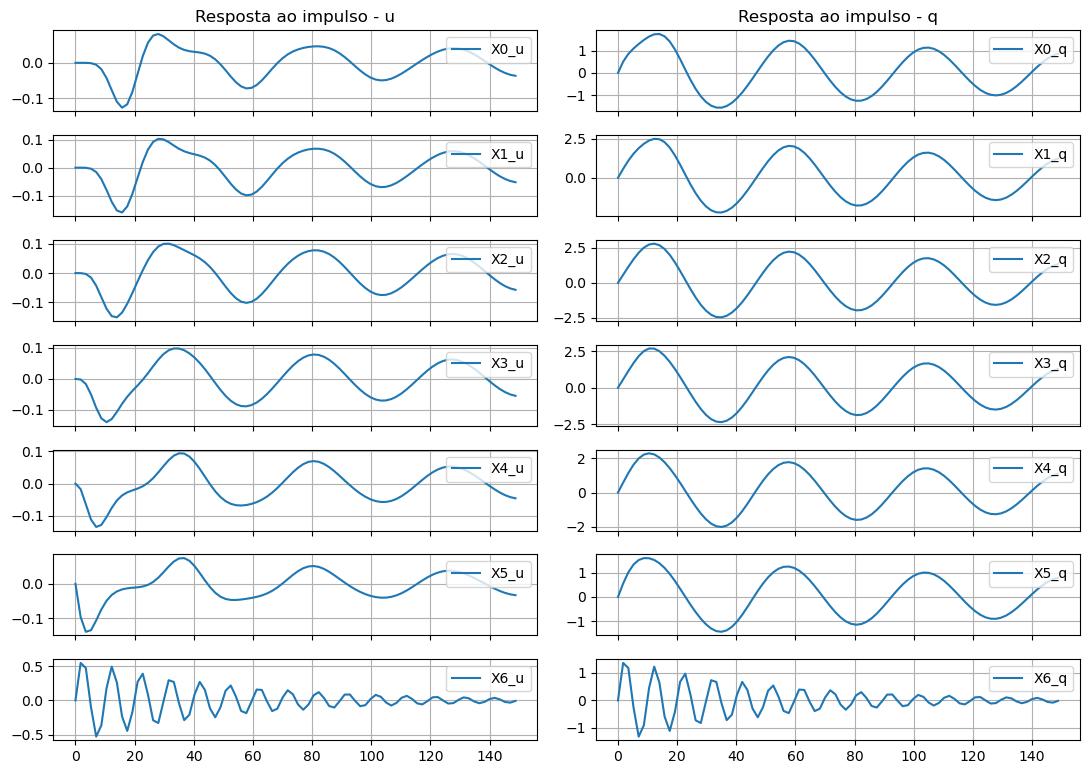

In [87]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Plot - resposta ao impulso
---

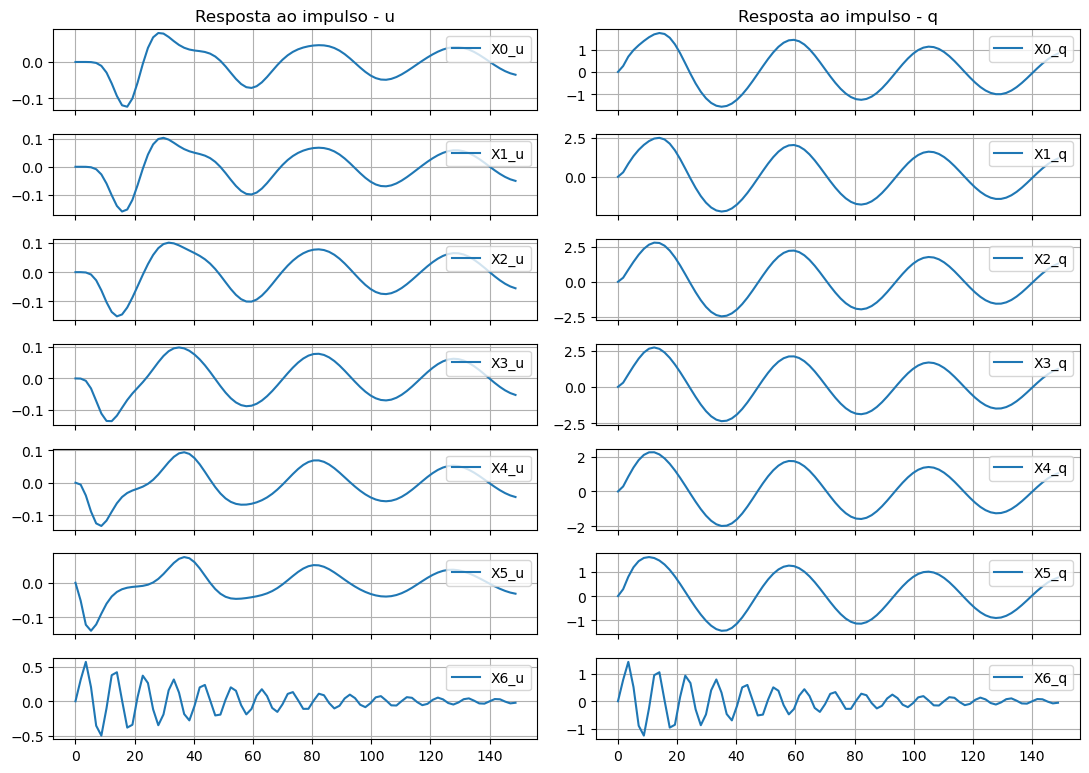

In [88]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_z_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Predição - usando CARIMA
---

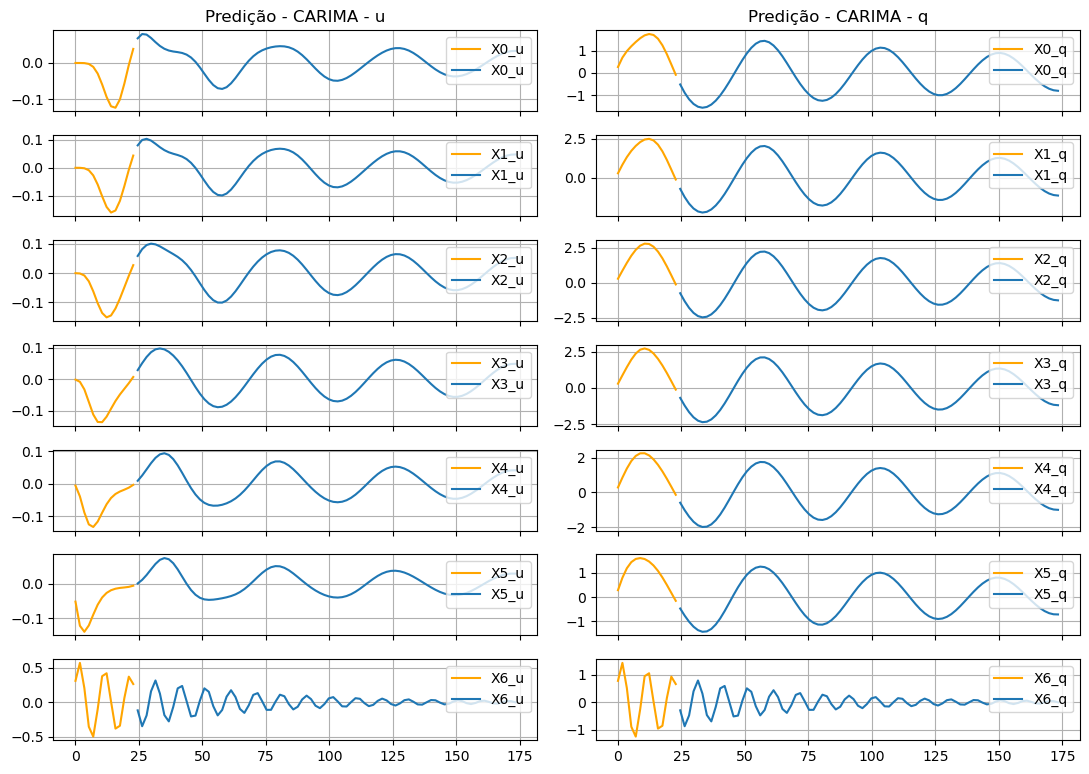

In [89]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        F = get_F(H_z_matriz[i][j], len(time))
        # pegar a condição inicial 
        y_in = y_matriz_out[i][j][0][1:F.shape[1]+1][::-1]

        # calcula a resposta livre
        y_out = F @ y_in

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', None]
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

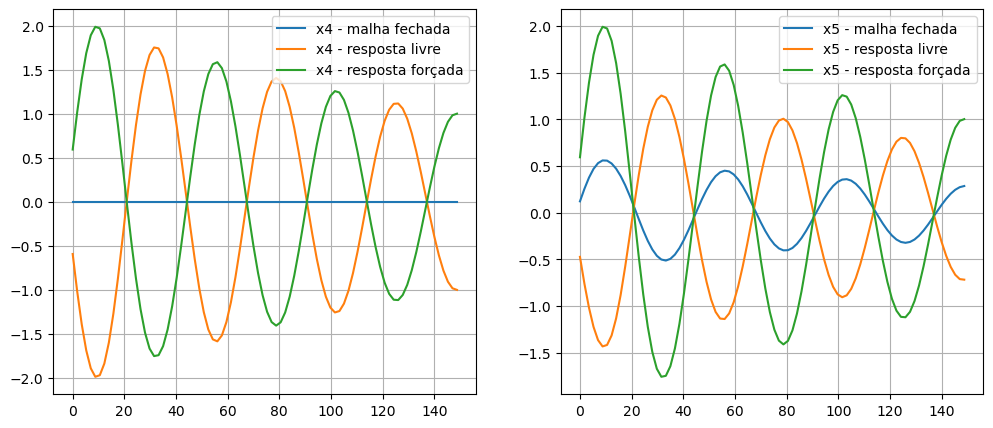

In [90]:
# ponderação nas ações de controle
alpha = 0.0
N_y = len(time)
N_u = len(time)

R = np.eye(N_u) * alpha
Q = np.eye(N_u) # monovariavel - delta é fixo = 1

F, G = generate_matrices(H_z_matriz[n_node-1][0], N_u, N_y)

# solution of quadratic problem
K = np.linalg.inv(G.T @ G + R) @ G.T

# solucao do sistema (free para a massa da nacele)
x0_free = y_pred[n_node-2][1][0]
u_opt = -K @ x0_free

# calcula a resposta forçada
x0_forced = G @ u_opt

# resposta total 
x0 = x0_free + x0_forced

x1_free = y_pred[n_node-1][1][0]
x1_forced = G @ u_opt
x1 = x1_free + x1_forced

# plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(time, x0, label='x{} - malha fechada'.format(n_node-2))
ax[0].plot(time, x0_free, label='x{} - resposta livre'.format(n_node-2))
ax[0].plot(time, x0_forced, label='x{} - resposta forçada'.format(n_node-2))

ax[1].plot(time, x1, label='x{} - malha fechada'.format(n_node-1))
ax[1].plot(time, x1_free, label='x{} - resposta livre'.format(n_node-1))
ax[1].plot(time, x1_forced, label='x{} - resposta forçada'.format(n_node-1))

for a in ax:
    a.grid()
    a.legend()
plt.show()
